<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log
import numpy as np
from os.path import isfile

from nlp.dataset import plot_frequencies, plot_roc, save_ngram_counts, DS_KWARGS
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace
from torch.optim import Adam

In [4]:
DS_NAME = 'wikicorpus'
LIMIT_PROP = 0.03
prec = LIMIT_PROP * 100

DS_ITEM_COUNTS_PATH = f"nlp/data/{prec}%_wikicorpus_2-grams.npz"

config={
        'ds_name': DS_NAME,
        'embed_type': 'CharNGram',
        'embed_dim': 100,
        'op': 'concat',
        'n': 2,
        "limit_prop": LIMIT_PROP,
        'num_workers': 10,
        "hidden_dim": 128,
        "dropout_prob": 0.0,
        "optim": Adam,
        "learning_rate": 0.0001,
        "batch_size": 128
        }

In [5]:
### get ngrams for wiki. we only used 10% of the data as dataset is huge. only run if necessary... ###

if not isfile(DS_ITEM_COUNTS_PATH):
    save_ngram_counts(cache=DS_ITEM_COUNTS_PATH, config=config, **DS_KWARGS[DS_NAME]);

# Actual Bigrams Frequency

there are 1146052 bigrams


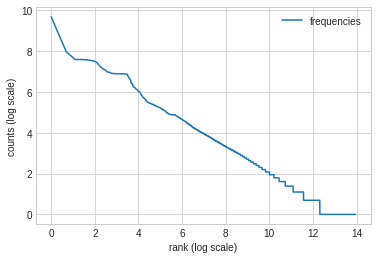

In [7]:
counts = np.load(DS_ITEM_COUNTS_PATH)['y']
print(f'there are {len(counts)} bigrams')
plot_frequencies(counts, 'rank (log scale)', 'counts (log scale)', 'frequencies')

In [8]:
indices = np.argsort(counts)
bigrams = np.load(DS_ITEM_COUNTS_PATH)['x']

print('Top 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[-5:]], counts[indices[-5:]])))

print('Bottom 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[:5]], counts[indices[:5]])))

Top 5 frequent bigrams and their counts:
[('100 females', 1954), ('65 years', 1982), ('0 till', 1985), ('median income', 2885), ('external links', 16118)]
Bottom 5 frequent bigrams and their counts:
[('purely sacerdotal', 1), ('vehicle shall', 1), ('vehicle insignia', 1), ('vehicle trade', 1), ('vehicle proved', 1)]


# Evaluate Original Count-Min and Count-Sketch

In [9]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE ='cmin_wikicorpus' #save_results to path
SEED = 69
N_HASHES = [1,2,3,4] 
SPACE_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS = 7 #n_processes used 
DATA_NAME ='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH = True

In [10]:
cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/3.0%_wikicorpus_2-grams.npz
data #: 1146052, shape (1146052,)
positive ratio: 1.72754, max 16118.000000, min 1.000000


count_sketch: # hashes 1, # buckets 100000 - loss 7.81	 time: 75.16 sec
count_sketch: # hashes 1, # buckets 350000 - loss 3.22	 time: 75.30 sec
count_sketch: # hashes 1, # buckets 75000 - loss 9.52	 time: 75.54 sec
count_sketch: # hashes 1, # buckets 750000 - loss 1.83	 time: 75.30 sec
count_sketch: # hashes 1, # buckets 25000 - loss 20.24	 time: 75.75 sec
count_sketch: # hashes 1, # buckets 400000 - loss 2.93	 time: 75.71 sec
count_sketch: # hashes 1, # buckets 450000 - loss 2.71	 time: 75.71 sec
count_sketch: # hashes 1, # buckets 150000 - loss 5.90	 time: 76.91 sec
count_sketch: # hashes 1, # buckets 300000 - loss 3.64	 time: 76.88 sec
count_sketch: # hashes 1, # buckets 1000000 - loss 1.47	 time: 76.78 sec
count_sketch: # hashes 1, # buckets 250000 - loss 4.14	 time: 77.45 sec
count_sketch: # hashes 1, # buckets 500000 - loss 2.49	 time: 77

In [11]:
### count min ###

COUNT_SKETCH = False

cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/3.0%_wikicorpus_2-grams.npz
data #: 1146052, shape (1146052,)
positive ratio: 1.72754, max 16118.000000, min 1.000000


count_min: # hashes 1, # buckets 100000 - loss 19.55	 time: 21.07 sec
count_min: # hashes 1, # buckets 25000 - loss 78.60	 time: 21.13 sec
count_min: # hashes 1, # buckets 150000 - loss 13.02	 time: 21.08 sec
count_min: # hashes 1, # buckets 125000 - loss 15.65	 time: 21.23 sec
count_min: # hashes 1, # buckets 225000 - loss 8.64	 time: 21.29 sec
count_min: # hashes 1, # buckets 175000 - loss 11.17	 time: 21.35 sec
count_min: # hashes 1, # buckets 75000 - loss 26.12	 time: 21.47 seccount_min: # hashes 1, # buckets 500000 - loss 3.87	 time: 21.22 sec

count_min: # hashes 1, # buckets 200000 - loss 9.72	 time: 21.46 sec
count_min: # hashes 1, # buckets 350000 - loss 5.55	 time: 21.45 sec
count_min: # hashes 1, # buckets 300000 - loss 6.46	 time: 21.48 sec
count_min: # hashes 1, # buckets 1000000 - loss 1.94	 time: 21.42 sec
count_min: # hashes 1, 

# Train Estimation model

In [3]:
targets, preds, model_size = train_simple_model(config=config,
        args={
            'max_epochs': 70
            })

Global seed set to 123
GPU available: True, used: False
TPU available: None, using: 0 TPU cores




HYPERPARAMS
-----------
{'args': {'max_epochs': 60}}
{'config': {'batch_size': 128,
            'dropout_prob': 0.0,
            'ds_name': 'wikicorpus',
            'embed_dim': 100,
            'embed_type': 'CharNGram',
            'hidden_dim': 128,
            'learning_rate': 0.0001,
            'limit_prop': 0.03,
            'n': 2,
            'num_workers': 44,
            'op': 'concat',
            'optim': <class 'torch.optim.adam.Adam'>}}




/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Loading features from: 
/data/home/daniel_nlp/learning-ds/nlp/data/3.0%_wikicorpus_2-grams_concat_CharNGram.100_features.npz


1146052it [00:20, 55031.67it/s]


Loading features from: 
/data/home/daniel_nlp/learning-ds/nlp/data/3.0%_wikicorpus_2-grams_concat_CharNGram.100_features.npz


481299it [00:08, 53479.54it/s]


KeyboardInterrupt: 

In [4]:
targets = {'train': '/data/home/daniel_nlp/learning-ds/nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_train.npz', 'test': '/data/home/daniel_nlp/learning-ds/nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz', 'valid': '/data/home/daniel_nlp/learning-ds/nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz'}
preds = '/data/home/daniel_nlp/learning-ds/nlp/pred_3.0%_wikicorpus_2-grams_concat_CharNGram.100.npz'

No Skill: ROC AUC=0.50
Learned: ROC AUC=0.86


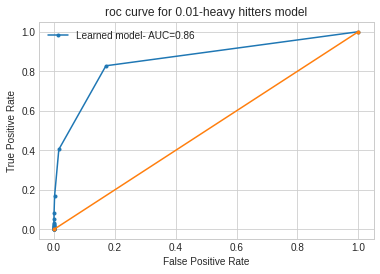

Saving plot...
Done.


<Figure size 432x288 with 0 Axes>

In [6]:
plot_roc(targets=targets, preds=preds, split='test', hh_frac=0.01)

In [5]:
TEST_RESULTS =[f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
VALID_RESULTS = [f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
TEST_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_test.npz"]
VALID_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz"]
LOOKUP_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_train.npz"]
SAVE ='cmin_wikicorpus'
SEED = 69
SPACE_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST = [1, 2, 3, 4]
PERFECT_ORDER = False
N_WORKERS = 7
DATA_NAME ='wikicorpus'
COUNT_SKETCH = False

In [8]:
# print('Running: with lookup, count min...')
# # with lookup

# lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
#                                 valid_results=VALID_RESULTS,
#                                 test_data=TEST_DATA, 
#                                 valid_data=VALID_DATA,
#                                 lookup_data=LOOKUP_DATA,
#                                 save=SAVE, 
#                                 seed=SEED,
#                                 space_list=SPACE_LIST,
#                                 n_hashes_list=N_HASHES_LIST,
#                                 perfect_order=PERFECT_ORDER,
#                                 n_workers=N_WORKERS, 
#                                 data_name=DATA_NAME,
#                                 count_sketch=COUNT_SKETCH
#                             )

# lcm.run()

Running: with lookup, count min...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-5811c0cb-a3fb-4648-9803-4058b6fd74b3.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


statistics for lookup data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_train.npz
data #: 458422, shape (458422,)
positive ratio: 1.75267, max 16118.000000, min 1.000000


data loading time: 1.1 sec
	loss_cf 0.00	loss_rd 27.07	loss_avg 27.07
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 26, # hashes 1, # cm buckets 22436 - loss 27.07	 time: 5.85 sec
	loss_cf 0.00	loss_rd 40.97	loss_avg 40

	loss_cf 0.00	loss_rd 57.28	loss_avg 57.28
	# uniq 0 # cm 343815	loss_cf 0.00	loss_rd 8.75	loss_avg 8.75

	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 3, # cm buckets 7596 - loss 57.28	 time: 9.89 sec
lookup_table_count_min: s_cut: 13, # hashes 1, # cm buckets 67348 - loss 8.75	 time: 6.41 sec
	loss_cf 0.00	loss_rd 59.74	loss_avg 59.74
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 7871 - loss 59.74	 time: 7.98 sec
	loss_cf 0.00	loss_rd 136.64	loss_avg 136.64
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 4, # cm buckets 3350 - loss 136.64	 time: 12.36 sec
	loss_cf 0.00	loss_rd 32.33	loss_avg 32.33
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 4, # cm buckets 11947 - loss 32.33	 time: 12.58 sec
	loss_cf 0.00	loss_rd 57.28	loss_avg 57.28
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 12, # hashes 2, # cm buckets 8200 - loss 57.28	 time: 9.16 sec
	loss_cf 0.00	loss_rd 11.94	loss_avg 11.94
	# 

	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 3, # cm buckets 4466 - loss 103.09	 time: 10.85 sec
	loss_cf 0.00	loss_rd 41.85	loss_avg 41.85
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 4, # cm buckets 9600 - loss 41.85	 time: 12.26 sec
	loss_cf 0.00	loss_rd 86.37	loss_avg 86.37
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 5247 - loss 86.37	 time: 10.37 sec
	loss_cf 0.00	loss_rd 6.56	loss_avg 6.56
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 8, # hashes 2, # cm buckets 55094 - loss 6.56	 time: 8.92 sec
	loss_cf 0.00	loss_rd 48.04	loss_avg 48.04
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 9, # hashes 1, # cm buckets 12294 - loss 48.04	 time: 6.27 sec
	loss_cf 0.00	loss_rd 57.34	loss_avg 57.34
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 3, # cm buckets 7596 - loss 57.34	 time: 10.03 sec
	loss_cf 0.00	loss_rd 18.97	loss_avg 18.97
	# uniq 0 # cm 343815
lookup_table_count_min: s_

lookup_table_count_min: s_cut: 9, # hashes 2, # cm buckets 43647 - loss 8.57	 time: 8.24 sec
	loss_cf 0.00	loss_rd 51.01	loss_avg 51.01
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 7, # hashes 4, # cm buckets 8072 - loss 51.01	 time: 12.95 sec
	loss_cf 0.00	loss_rd 8.05	loss_avg 8.05
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 1, # cm buckets 72790 - loss 8.05	 time: 6.03 sec
	loss_cf 0.00	loss_rd 14.52	loss_avg 14.52
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 1, # cm buckets 40742 - loss 14.52	 time: 5.98 sec
	loss_cf 0.00	loss_rd 75.53	loss_avg 75.53
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 4, # cm buckets 5697 - loss 75.53	 time: 11.55 sec
	loss_cf 0.00	loss_rd 39.13	loss_avg 39.13
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 10185 - loss 39.13	 time: 11.70 sec
	loss_cf 0.00	loss_rd 86.59	loss_avg 86.59
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 3, # c

	loss_cf 0.00	loss_rd 5.09	loss_avg 5.09
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 3, # cm buckets 57596 - loss 5.09	 time: 10.71 sec
	loss_cf 0.00	loss_rd 5.27	loss_avg 5.27
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 1, # cm buckets 113400 - loss 5.27	 time: 6.62 sec
	loss_cf 0.00	loss_rd 15.01	loss_avg 15.01
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 22685 - loss 15.01	 time: 12.41 sec
	loss_cf 0.00	loss_rd 12.03	loss_avg 12.03
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 32871 - loss 12.03	 time: 7.97 sec
	loss_cf 0.00	loss_rd 39.01	loss_avg 39.01
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 10185 - loss 39.01	 time: 12.42 sec
	loss_cf 0.00	loss_rd 15.06	loss_avg 15.06
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 22685 - loss 15.06	 time: 11.52 sec
	loss_cf 0.00	loss_rd 6.33	loss_avg 6.33
	# uni

lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 13580 - loss 29.72	 time: 10.42 sec
	loss_cf 0.00	loss_rd 26.39	loss_avg 26.39
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 22720 - loss 26.39	 time: 6.60 sec
	loss_cf 0.00	loss_rd 11.45	loss_avg 11.45
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 30247 - loss 11.45	 time: 10.12 sec
	loss_cf 0.00	loss_rd 22.20	loss_avg 22.20
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 16435 - loss 22.20	 time: 11.89 sec
	loss_cf 0.00	loss_rd 12.12	loss_avg 12.12
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 32871 - loss 12.12	 time: 8.18 sec
	loss_cf 0.00	loss_rd 24.72	loss_avg 24.72
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 15906 - loss 24.72	 time: 10.53 sec
	loss_cf 0.00	loss_rd 39.91	loss_avg 39.91
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes

	loss_cf 0.00	loss_rd 76.01	loss_avg 76.01
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 5680 - loss 76.01	 time: 12.40 sec
	loss_cf 0.00	loss_rd 17.40	loss_avg 17.40
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 23860 - loss 17.40	 time: 8.99 sec
	loss_cf 0.00	loss_rd 8.38	loss_avg 8.38
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 72720 - loss 8.38	 time: 6.33 sec
	loss_cf 0.00	loss_rd 57.52	loss_avg 57.52
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 7573 - loss 57.52	 time: 10.79 sec
	loss_cf 0.00	loss_rd 26.45	loss_avg 26.45
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 22720 - loss 26.45	 time: 6.46 sec
	loss_cf 0.00	loss_rd 24.72	loss_avg 24.72
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 15906 - loss 24.72	 time: 11.90 sec
	loss_cf 0.00	loss_rd 19.67	loss_avg 19.67
	# un

lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 23860 - loss 17.41	 time: 9.36 sec
	loss_cf 0.00	loss_rd 19.70	loss_avg 19.70
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 18180 - loss 19.70	 time: 11.92 sec
	loss_cf 0.00	loss_rd 2.68	loss_avg 2.68
	# uniq 0 # cm 343815
	loss_cf 0.00	loss_rd 15.01	loss_avg 15.01
	# uniq 0lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 222720 - loss 2.68	 time: 6.34 sec 
# cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 24240 - loss 15.01	 time: 10.81 sec
	loss_cf 0.00	loss_rd 5.72	loss_avg 5.72
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 61360 - loss 5.72	 time: 8.10 sec
	loss_cf 0.00	loss_rd 2.22	loss_avg 2.22
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 1, # cm buckets 263400 - loss 2.22	 time: 6.10 sec
	loss_cf 0.00	loss_rd 2.75	loss_avg 2.75
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm bu

	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 55680 - loss 4.70	 time: 12.94 sec
	loss_cf 0.00	loss_rd 4.84	loss_avg 4.84
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 122720 - loss 4.84	 time: 6.00 sec
	loss_cf 0.00	loss_rd 10.28	loss_avg 10.28
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 30680 - loss 10.28	 time: 11.73 sec
	loss_cf 0.00	loss_rd 2.90	loss_avg 2.90
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 2, # cm buckets 106700 - loss 2.90	 time: 8.65 sec
	loss_cf 0.00	loss_rd 5.06	loss_avg 5.06
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 57573 - loss 5.06	 time: 10.89 sec
	loss_cf 0.00	loss_rd 3.76	loss_avg 3.76
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 86360 - loss 3.76	 time: 8.82 sec
	loss_cf 0.00	loss_rd 2.68	loss_avg 2.68
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, 

	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 222720 - loss 2.68	 time: 6.31 sec
	loss_cf 0.00	loss_rd 2.08	loss_avg 2.08
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 136360 - loss 2.08	 time: 8.91 sec
	loss_cf 0.00	loss_rd 3.37	loss_avg 3.37
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 172720 - loss 3.37	 time: 6.31 sec
	loss_cf 0.00	loss_rd 2.15	loss_avg 2.15
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 107573 - loss 2.15	 time: 10.45 sec
	loss_cf 0.00	loss_rd 4.66	loss_avg 4.66
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 55680 - loss 4.66	 time: 12.26 sec
	loss_cf 0.00	loss_rd 1.77	loss_avg 1.77
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 322720 - loss 1.77	 time: 6.33 sec
	loss_cf 0.00	loss_rd 2.77	loss_avg 2.77
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, #

	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 143180 - loss 1.09	 time: 13.06 sec
	loss_cf 0.00	loss_rd 2.73	loss_avg 2.73
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 80680 - loss 2.73	 time: 12.28 sec
	loss_cf 0.00	loss_rd 9.18	loss_avg 9.18
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 41578 - loss 9.18	 time: 8.86 sec
	loss_cf 0.00	loss_rd 12.74	loss_avg 12.74
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 27718 - loss 12.74	 time: 10.76 sec
	loss_cf 0.00	loss_rd 2.16	loss_avg 2.16
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 272720 - loss 2.16	 time: 6.72 sec
	loss_cf 0.00	loss_rd 2.10	loss_avg 2.10
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 136360 - loss 2.10	 time: 8.31 sec
	loss_cf 0.00	loss_rd 2.15	loss_avg 2.15
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1,

	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 83156 - loss 7.13	 time: 6.26 sec
	loss_cf 0.00	loss_rd 1.67	loss_avg 1.67
	# uniq 0 # cm 343815
	loss_cf 0.00	loss_rd 3.51	loss_avg 3.51
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 161360 - loss 1.67	 time: 8.40 sec
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 68180 - loss 3.51	 time: 11.55 sec
	loss_cf 0.00	loss_rd 2.78	loss_avg 2.78
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 272720 - loss 2.78	 time: 6.26 sec
	loss_cf 0.00	loss_rd 1.09	loss_avg 1.09
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 143180 - loss 1.09	 time: 13.32 sec
	loss_cf 0.00	loss_rd 2.14	loss_avg 2.14
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 272720 - loss 2.14	 time: 6.45 sec
	loss_cf 0.00	loss_rd 12.74	loss_avg 12.74
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 0, 

	loss_cf 0.00	loss_rd 8.66	loss_avg 8.66
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 13, # hashes 1, # cm buckets 67348 - loss 8.66	 time: 5.92 sec
	loss_cf 0.00	loss_rd 6.45	loss_avg 6.45
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 10, # hashes 1, # cm buckets 88956 - loss 6.45	 time: 5.60 sec
	loss_cf 0.00	loss_rd 5.16	loss_avg 5.16
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 9, # hashes 1, # cm buckets 112294 - loss 5.16	 time: 6.19 sec
	loss_cf 0.00	loss_rd 4.28	loss_avg 4.28
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 7, # hashes 1, # cm buckets 132288 - loss 4.28	 time: 5.64 sec
	loss_cf 0.00	loss_rd 3.69	loss_avg 3.69
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 7, # hashes 1, # cm buckets 157288 - loss 3.69	 time: 5.63 sec
	loss_cf 0.00	loss_rd 3.24	loss_avg 3.24
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 6, # hashes 1, # cm buckets 178182 - loss 3.24	 time: 6.54 sec
	loss_cf 0.00	loss_rd 2.95	loss_avg 2.95
	# uniq 0 # cm 34

In [9]:
print('Running: no lookup, only using learned model count min...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: no lookup, only using learned model count min...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-5811c0cb-a3fb-4648-9803-4058b6fd74b3.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


data loading time: 0.7 sec
	loss_cf 0.00	loss_rd 12.95	loss_avg 10.50
cutoff_count_min_param: bcut: 18750, # hashes 1, # buckets 56250 - loss 10.50	 time: 5.53 sec
	loss_cf 0.00	loss_rd 14.52	loss_avg 10.66
cutoff_count_min_param: bcut: 35000, # hashes 1, # buckets 65000 - loss 10.66	 time: 5.54 sec
	loss_cf 0.00	loss_rd 24.79	loss_avg 23.33
cutoff_count_min_param: bcut: 1250, # hashe

	loss_cf 0.00	loss_rd 40.89	loss_avg 28.19
cutoff_count_min_param: bcut: 45000, # hashes 1, # buckets 55000 - loss 28.19	 time: 5.25 sec
	loss_cf 0.00	loss_rd 181.79	loss_avg 154.68
cutoff_count_min_param: bcut: 10000, # hashes 2, # buckets 12500 - loss 154.68	 time: 8.26 sec
	loss_cf 0.00	loss_rd 19.85	loss_avg 16.68
cutoff_count_min_param: bcut: 12500, # hashes 1, # buckets 37500 - loss 16.68	 time: 5.42 sec
	loss_cf 0.00	loss_rd 20.36	loss_avg 15.73
cutoff_count_min_param: bcut: 26250, # hashes 1, # buckets 48750 - loss 15.73	 time: 5.86 sec
	loss_cf 0.00	loss_rd 30.51	loss_avg 27.55
cutoff_count_min_param: bcut: 3750, # hashes 1, # buckets 21250 - loss 27.55	 time: 5.69 sec
	loss_cf 0.00	loss_rd 14.16	loss_avg 11.75
cutoff_count_min_param: bcut: 15000, # hashes 3, # buckets 38333 - loss 11.75	 time: 9.60 sec
	loss_cf 0.00	loss_rd 72.03	loss_avg 49.65
cutoff_count_min_param: bcut: 45000, # hashes 2, # buckets 50000 - loss 49.65	 time: 7.51 sec
	loss_cf 0.00	loss_rd 15.82	loss_avg 14

cutoff_count_min_param: bcut: 17500, # hashes 1, # buckets 32500 - loss 26.62	 time: 6.19 sec
	loss_cf 0.00	loss_rd 113.43	loss_avg 100.52
cutoff_count_min_param: bcut: 5000, # hashes 4, # buckets 8750 - loss 100.52	 time: 12.04 sec
	loss_cf 0.00	loss_rd 6.74	loss_avg 5.66
cutoff_count_min_param: bcut: 12500, # hashes 2, # buckets 62500 - loss 5.66	 time: 7.48 sec
	loss_cf 0.00	loss_rd 41.51	loss_avg 36.21
	loss_cf 0.00	loss_rd 104.31	loss_avg 77.12
cutoff_count_min_param: bcut: 6250, # hashes 1, # buckets 18750 - loss 36.21	 time: 5.74 sec
cutoff_count_min_param: bcut: 33750, # hashes 2, # buckets 37500 - loss 77.12	 time: 7.55 sec
	loss_cf 0.00	loss_rd 20.25	loss_avg 17.12
cutoff_count_min_param: bcut: 11250, # hashes 3, # buckets 28750 - loss 17.12	 time: 9.63 sec
	loss_cf 0.00	loss_rd 54.81	loss_avg 44.78
cutoff_count_min_param: bcut: 17500, # hashes 2, # buckets 25000 - loss 44.78	 time: 7.61 sec
	loss_cf 0.00	loss_rd 25.72	loss_avg 23.69
cutoff_count_min_param: bcut: 2500, # hash

cutoff_count_min_param: bcut: 45000, # hashes 2, # buckets 75000 - loss 7.05	 time: 8.07 sec
	loss_cf 0.00	loss_rd 53.16	loss_avg 29.52
cutoff_count_min_param: bcut: 90000, # hashes 4, # buckets 95000 - loss 29.52	 time: 10.16 sec
	loss_cf 0.00	loss_rd 6.44	loss_avg 4.58
cutoff_count_min_param: bcut: 40000, # hashes 3, # buckets 80000 - loss 4.58	 time: 10.75 sec
	loss_cf 0.00	loss_rd 3.88	loss_avg 3.34
cutoff_count_min_param: bcut: 7500, # hashes 1, # buckets 142500 - loss 3.34	 time: 6.37 sec
	loss_cf 0.00	loss_rd 7.81	loss_avg 6.38
cutoff_count_min_param: bcut: 17500, # hashes 4, # buckets 52500 - loss 6.38	 time: 12.23 sec
	loss_cf 0.00	loss_rd 16.42	loss_avg 9.83
cutoff_count_min_param: bcut: 70000, # hashes 2, # buckets 87500 - loss 9.83	 time: 7.69 sec
	loss_cf 0.00	loss_rd 2.48	loss_avg 2.10
cutoff_count_min_param: bcut: 11250, # hashes 1, # buckets 213750 - loss 2.10	 time: 6.27 sec
	loss_cf 0.00	loss_rd 3.72	loss_avg 2.88
cutoff_count_min_param: bcut: 26250, # hashes 1, # buc

cutoff_count_min_param: bcut: 60000, # hashes 3, # buckets 70000 - loss 18.21	 time: 8.52 sec
	loss_cf 0.00	loss_rd 5.46	loss_avg 4.31
cutoff_count_min_param: bcut: 22500, # hashes 4, # buckets 67500 - loss 4.31	 time: 13.34 sec
	loss_cf 0.00	loss_rd 4.51	loss_avg 3.57
cutoff_count_min_param: bcut: 22500, # hashes 1, # buckets 127500 - loss 3.57	 time: 5.38 sec
	loss_cf 0.00	loss_rd 4.70	loss_avg 3.26
cutoff_count_min_param: bcut: 43750, # hashes 1, # buckets 131250 - loss 3.26	 time: 5.19 sec
	loss_cf 0.00	loss_rd 12.33	loss_avg 7.69
cutoff_count_min_param: bcut: 60000, # hashes 4, # buckets 80000 - loss 7.69	 time: 9.99 sec
	loss_cf 0.00	loss_rd 18.66	loss_avg 13.48
cutoff_count_min_param: bcut: 37500, # hashes 3, # buckets 54166 - loss 13.48	 time: 8.89 sec
	loss_cf 0.00	loss_rd 4.51	loss_avg 3.84
cutoff_count_min_param: bcut: 10000, # hashes 3, # buckets 70000 - loss 3.84	 time: 9.59 sec
	loss_cf 0.00	loss_rd 2.81	loss_avg 2.08
cutoff_count_min_param: bcut: 33750, # hashes 1, # buc

cutoff_count_min_param: bcut: 45000, # hashes 4, # buckets 78750 - loss 4.84	 time: 10.27 sec
	loss_cf 0.00	loss_rd 7.03	loss_avg 4.34
cutoff_count_min_param: bcut: 61250, # hashes 1, # buckets 113750 - loss 4.34	 time: 5.87 sec
	loss_cf 0.00	loss_rd 37.96	loss_avg 25.34
cutoff_count_min_param: bcut: 50000, # hashes 3, # buckets 58333 - loss 25.34	 time: 8.57 sec
	loss_cf 0.00	loss_rd 27.73	loss_avg 15.40
cutoff_count_min_param: bcut: 90000, # hashes 2, # buckets 100000 - loss 15.40	 time: 6.49 sec
	loss_cf 0.00	loss_rd 3.39	loss_avg 2.17
cutoff_count_min_param: bcut: 56250, # hashes 1, # buckets 168750 - loss 2.17	 time: 5.07 sec
	loss_cf 0.00	loss_rd 5.62	loss_avg 4.25
cutoff_count_min_param: bcut: 30000, # hashes 3, # buckets 76666 - loss 4.25	 time: 9.48 sec
	loss_cf 0.00	loss_rd 8.23	loss_avg 5.95
cutoff_count_min_param: bcut: 37500, # hashes 2, # buckets 75000 - loss 5.95	 time: 7.31 sec
	loss_cf 0.00	loss_rd 7.04	loss_avg 6.03
cutoff_count_min_param: bcut: 8750, # hashes 4, # bu

cutoff_count_min_param: bcut: 50000, # hashes 1, # buckets 200000 - loss 1.78	 time: 6.55 sec
	loss_cf 0.00	loss_rd 1.45	loss_avg 0.84
cutoff_count_min_param: bcut: 80000, # hashes 1, # buckets 320000 - loss 0.84	 time: 5.66 sec
	loss_cf 0.00	loss_rd 2.16	loss_avg 1.59
cutoff_count_min_param: bcut: 35000, # hashes 3, # buckets 128333 - loss 1.59	 time: 9.86 sec
	loss_cf 0.00	loss_rd 7.36	loss_avg 4.09
cutoff_count_min_param: bcut: 90000, # hashes 1, # buckets 135000 - loss 4.09	 time: 5.33 sec
	loss_cf 0.00	loss_rd 1.85	loss_avg 1.53
cutoff_count_min_param: bcut: 15000, # hashes 1, # buckets 285000 - loss 1.53	 time: 6.65 sec
	loss_cf 0.00	loss_rd 5.31	loss_avg 2.37
cutoff_count_min_param: bcut: 140000, # hashes 2, # buckets 175000 - loss 2.37	 time: 6.39 sec
	loss_cf 0.00	loss_rd 3.65	loss_avg 2.03
cutoff_count_min_param: bcut: 90000, # hashes 2, # buckets 150000 - loss 2.03	 time: 7.37 sec
	loss_cf 0.00	loss_rd 3.36	loss_avg 2.25
cutoff_count_min_param: bcut: 50000, # hashes 2, # buc

cutoff_count_min_param: bcut: 120000, # hashes 2, # buckets 200000 - loss 1.07	 time: 6.51 sec
	loss_cf 0.00	loss_rd 2.64	loss_avg 1.58
cutoff_count_min_param: bcut: 70000, # hashes 3, # buckets 140000 - loss 1.58	 time: 9.03 sec
	loss_cf 0.00	loss_rd 1.62	loss_avg 1.30
cutoff_count_min_param: bcut: 20000, # hashes 3, # buckets 140000 - loss 1.30	 time: 10.83 sec
	loss_cf 0.00	loss_rd 3.56	loss_avg 2.69
cutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 90000 - loss 2.69	 time: 13.39 sec
	loss_cf 0.00	loss_rd 2.48	loss_avg 2.09
cutoff_count_min_param: bcut: 12500, # hashes 2, # buckets 125000 - loss 2.09	 time: 8.73 sec
	loss_cf 0.00	loss_rd 9.98	loss_avg 4.89
cutoff_count_min_param: bcut: 120000, # hashes 3, # buckets 140000 - loss 4.89	 time: 7.73 sec
	loss_cf 0.00	loss_rd 4.88	loss_avg 2.87
cutoff_count_min_param: bcut: 75000, # hashes 2, # buckets 125000 - loss 2.87	 time: 7.76 sec
	loss_cf 0.00	loss_rd 2.91	loss_avg 1.43
cutoff_count_min_param: bcut: 120000, # hashes 3, # 

cutoff_count_min_param: bcut: 112500, # hashes 3, # buckets 287500 - loss 0.25	 time: 8.28 sec
	loss_cf 0.00	loss_rd 1.68	loss_avg 0.62
cutoff_count_min_param: bcut: 175000, # hashes 2, # buckets 250000 - loss 0.62	 time: 5.15 sec
	loss_cf 0.00	loss_rd 1.88	loss_avg 0.95
cutoff_count_min_param: bcut: 112500, # hashes 3, # buckets 187500 - loss 0.95	 time: 7.91 sec
	loss_cf 0.00	loss_rd 7.89	loss_avg 2.84
cutoff_count_min_param: bcut: 180000, # hashes 2, # buckets 200000 - loss 2.84	 time: 5.03 sec
	loss_cf 0.00	loss_rd 0.08	loss_avg 0.02
cutoff_count_min_param: bcut: 250000, # hashes 4, # buckets 375000 - loss 0.02	 time: 4.93 sec
	loss_cf 0.00	loss_rd 0.44	loss_avg 0.29
cutoff_count_min_param: bcut: 50000, # hashes 1, # buckets 950000 - loss 0.29	 time: 5.91 sec
	loss_cf 0.00	loss_rd 0.13	loss_avg 0.01
cutoff_count_min_param: bcut: 300000, # hashes 1, # buckets 700000 - loss 0.01	 time: 2.41 sec
	loss_cf 0.00	loss_rd 2.13	loss_avg 0.79
cutoff_count_min_param: bcut: 175000, # hashes 3,

cutoff_count_min_param: bcut: 187500, # hashes 3, # buckets 312500 - loss 0.15	 time: 6.09 sec
	loss_cf 0.00	loss_rd 1.02	loss_avg 0.60
cutoff_count_min_param: bcut: 75000, # hashes 1, # buckets 425000 - loss 0.60	 time: 5.35 sec
	loss_cf 0.00	loss_rd 7.53	loss_avg 1.98
cutoff_count_min_param: bcut: 225000, # hashes 4, # buckets 237500 - loss 1.98	 time: 5.70 sec
	loss_cf 0.00	loss_rd 1.69	loss_avg 1.34
cutoff_count_min_param: bcut: 22500, # hashes 4, # buckets 123750 - loss 1.34	 time: 12.40 sec
	loss_cf 0.00	loss_rd 2.87	loss_avg 1.17
cutoff_count_min_param: bcut: 157500, # hashes 3, # buckets 202500 - loss 1.17	 time: 6.66 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.13
cutoff_count_min_param: bcut: 100000, # hashes 3, # buckets 366666 - loss 0.13	 time: 8.37 sec
	loss_cf 0.00	loss_rd 0.54	loss_avg 0.18
cutoff_count_min_param: bcut: 187500, # hashes 4, # buckets 281250 - loss 0.18	 time: 6.93 sec
	loss_cf 0.00	loss_rd 0.63	loss_avg 0.45
cutoff_count_min_param: bcut: 37500, # hashes 1, 

cutoff_count_min_param: bcut: 250000, # hashes 1, # buckets 750000 - loss 0.05	 time: 3.19 sec
	loss_cf 0.00	loss_rd 1.18	loss_avg 0.56
cutoff_count_min_param: bcut: 125000, # hashes 2, # buckets 250000 - loss 0.56	 time: 6.42 sec
	loss_cf 0.00	loss_rd 0.11	loss_avg 0.02
cutoff_count_min_param: bcut: 250000, # hashes 2, # buckets 500000 - loss 0.02	 time: 4.06 sec
	loss_cf 0.00	loss_rd 0.91	loss_avg 0.71
cutoff_count_min_param: bcut: 25000, # hashes 2, # buckets 250000 - loss 0.71	 time: 8.50 sec
	loss_cf 0.00	loss_rd 0.61	loss_avg 0.36
cutoff_count_min_param: bcut: 75000, # hashes 4, # buckets 225000 - loss 0.36	 time: 10.43 sec
	loss_cf 0.00	loss_rd 1.92	loss_avg 1.16
cutoff_count_min_param: bcut: 67500, # hashes 4, # buckets 146250 - loss 1.16	 time: 10.92 sec
	loss_cf 0.00	loss_rd 0.57	loss_avg 0.29
cutoff_count_min_param: bcut: 112500, # hashes 1, # buckets 637500 - loss 0.29	 time: 4.92 sec
	loss_cf 0.00	loss_rd 1.49	loss_avg 0.71
cutoff_count_min_param: bcut: 125000, # hashes 3,

In [10]:
print('Running: perfect oracle... only using learned model count min...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: perfect oracle... only using learned model count min...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-5811c0cb-a3fb-4648-9803-4058b6fd74b3.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


data loading time: 0.9 sec
	loss_cf 0.00	loss_rd 11.36	loss_avg 6.51
cutoff_count_min_param_perfect: bcut: 35000, # hashes 1, # buckets 65000 - loss 6.51	 time: 6.09 sec
	loss_cf 0.00	loss_rd 10.32	loss_avg 6.72
cutoff_count_min_param_perfect: bcut: 18750, # hashes 1, # buckets 56250 - loss 6.72	 time: 6.29 sec
	loss_cf 0.00	loss_rd 12.62	loss_avg 9.38
cutoff_count_min_param_pe

	loss_cf 0.00	loss_rd 41.73	loss_avg 26.31
cutoff_count_min_param_perfect: bcut: 22500, # hashes 4, # buckets 30000 - loss 26.31	 time: 12.52 sec
	loss_cf 0.00	loss_rd 9.17	loss_avg 6.21
cutoff_count_min_param_perfect: bcut: 15000, # hashes 2, # buckets 50000 - loss 6.21	 time: 9.44 sec
	loss_cf 0.00	loss_rd 160.97	loss_avg 115.43
cutoff_count_min_param_perfect: bcut: 10000, # hashes 2, # buckets 12500 - loss 115.43	 time: 8.93 sec
	loss_cf 0.00	loss_rd 32.08	loss_avg 17.30
cutoff_count_min_param_perfect: bcut: 45000, # hashes 1, # buckets 55000 - loss 17.30	 time: 5.62 sec
	loss_cf 0.00	loss_rd 81.99	loss_avg 67.61
cutoff_count_min_param_perfect: bcut: 2500, # hashes 4, # buckets 7500 - loss 67.61	 time: 12.65 sec
	loss_cf 0.00	loss_rd 16.53	loss_avg 11.49
cutoff_count_min_param_perfect: bcut: 12500, # hashes 1, # buckets 37500 - loss 11.49	 time: 6.03 sec
	loss_cf 0.00	loss_rd 16.17	loss_avg 9.89
cutoff_count_min_param_perfect: bcut: 26250, # hashes 1, # buckets 48750 - loss 9.89	 ti

cutoff_count_min_param_perfect: bcut: 30000, # hashes 4, # buckets 33750 - loss 49.26	 time: 12.22 sec
	loss_cf 0.00	loss_rd 4.14	loss_avg 2.88
cutoff_count_min_param_perfect: bcut: 12500, # hashes 1, # buckets 112500 - loss 2.88	 time: 6.02 sec
	loss_cf 0.00	loss_rd 12.25	loss_avg 7.57
cutoff_count_min_param_perfect: bcut: 25000, # hashes 2, # buckets 50000 - loss 7.57	 time: 8.43 sec
	loss_cf 0.00	loss_rd 17.58	loss_avg 14.49
cutoff_count_min_param_perfect: bcut: 2500, # hashes 2, # buckets 25000 - loss 14.49	 time: 8.65 sec
	loss_cf 0.00	loss_rd 26.17	loss_avg 17.26
cutoff_count_min_param_perfect: bcut: 17500, # hashes 1, # buckets 32500 - loss 17.26	 time: 6.14 sec
	loss_cf 0.00	loss_rd 45.74	loss_avg 26.40
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 41250 - loss 26.40	 time: 5.97 sec
	loss_cf 0.00	loss_rd 106.88	loss_avg 83.01
cutoff_count_min_param_perfect: bcut: 5000, # hashes 4, # buckets 8750 - loss 83.01	 time: 12.71 sec
	loss_cf 0.00	loss_rd 18.83	loss

	loss_cf 0.00	loss_rd 4.03	loss_avg 2.66
cutoff_count_min_param_perfect: bcut: 17500, # hashes 2, # buckets 87500 - loss 2.66	 time: 9.11 sec
	loss_cf 0.00	loss_rd 64.28	loss_avg 32.24
cutoff_count_min_param_perfect: bcut: 56250, # hashes 3, # buckets 60416 - loss 32.24	 time: 9.79 sec
	loss_cf 0.00	loss_rd 5.34	loss_avg 2.88
cutoff_count_min_param_perfect: bcut: 45000, # hashes 1, # buckets 105000 - loss 2.88	 time: 5.91 sec
	loss_cf 0.00	loss_rd 17.16	loss_avg 8.32
cutoff_count_min_param_perfect: bcut: 61250, # hashes 4, # buckets 74375 - loss 8.32	 time: 10.84 sec
	loss_cf 0.00	loss_rd 4.90	loss_avg 3.03
cutoff_count_min_param_perfect: bcut: 25000, # hashes 1, # buckets 100000 - loss 3.03	 time: 7.05 sec
	loss_cf 0.00	loss_rd 43.48	loss_avg 18.55
cutoff_count_min_param_perfect: bcut: 90000, # hashes 4, # buckets 95000 - loss 18.55	 time: 9.53 sec
	loss_cf 0.00	loss_rd 5.73	loss_avg 3.19
cutoff_count_min_param_perfect: bcut: 40000, # hashes 3, # buckets 80000 - loss 3.19	 time: 9.70 

	loss_cf 0.00	loss_rd 17.13	loss_avg 10.05
cutoff_count_min_param_perfect: bcut: 31250, # hashes 4, # buckets 46875 - loss 10.05	 time: 11.90 sec
	loss_cf 0.00	loss_rd 4.94	loss_avg 2.83
cutoff_count_min_param_perfect: bcut: 35000, # hashes 2, # buckets 87500 - loss 2.83	 time: 8.19 sec
	loss_cf 0.00	loss_rd 6.90	loss_avg 4.67
cutoff_count_min_param_perfect: bcut: 15000, # hashes 3, # buckets 55000 - loss 4.67	 time: 10.66 sec
	loss_cf 0.00	loss_rd 2.37	loss_avg 1.70
cutoff_count_min_param_perfect: bcut: 10000, # hashes 1, # buckets 190000 - loss 1.70	 time: 6.70 sec
	loss_cf 0.00	loss_rd 16.85	loss_avg 8.24
cutoff_count_min_param_perfect: bcut: 60000, # hashes 2, # buckets 75000 - loss 8.24	 time: 7.66 sec
	loss_cf 0.00	loss_rd 6.72	loss_avg 3.80
cutoff_count_min_param_perfect: bcut: 37500, # hashes 1, # buckets 87500 - loss 3.80	 time: 7.35 sec
	loss_cf 0.00	loss_rd 8.11	loss_avg 3.97
cutoff_count_min_param_perfect: bcut: 60000, # hashes 3, # buckets 86666 - loss 3.97	 time: 9.75 sec

	loss_cf 0.00	loss_rd 6.03	loss_avg 3.88
cutoff_count_min_param_perfect: bcut: 20000, # hashes 4, # buckets 60000 - loss 3.88	 time: 12.31 sec
	loss_cf 0.00	loss_rd 3.79	loss_avg 2.77
cutoff_count_min_param_perfect: bcut: 8750, # hashes 2, # buckets 87500 - loss 2.77	 time: 8.60 sec
	loss_cf 0.00	loss_rd 16.09	loss_avg 7.14
cutoff_count_min_param_perfect: bcut: 80000, # hashes 3, # buckets 93333 - loss 7.14	 time: 10.46 sec
	loss_cf 0.00	loss_rd 12.42	loss_avg 6.49
cutoff_count_min_param_perfect: bcut: 50000, # hashes 1, # buckets 75000 - loss 6.49	 time: 5.77 sec
	loss_cf 0.00	loss_rd 2.51	loss_avg 1.49
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 170000 - loss 1.49	 time: 5.90 sec
	loss_cf 0.00	loss_rd 8.62	loss_avg 5.11
cutoff_count_min_param_perfect: bcut: 30000, # hashes 3, # buckets 60000 - loss 5.11	 time: 10.65 sec
	loss_cf 0.00	loss_rd 9.97	loss_avg 5.13
cutoff_count_min_param_perfect: bcut: 52500, # hashes 3, # buckets 75833 - loss 5.13	 time: 9.79 sec
	

	loss_cf 0.00	loss_rd 6.29	loss_avg 2.80
cutoff_count_min_param_perfect: bcut: 78750, # hashes 2, # buckets 112500 - loss 2.80	 time: 7.22 sec
	loss_cf 0.00	loss_rd 3.65	loss_avg 2.06
cutoff_count_min_param_perfect: bcut: 37500, # hashes 3, # buckets 95833 - loss 2.06	 time: 10.04 sec
	loss_cf 0.00	loss_rd 2.46	loss_avg 1.62
cutoff_count_min_param_perfect: bcut: 17500, # hashes 4, # buckets 96250 - loss 1.62	 time: 12.25 sec
	loss_cf 0.00	loss_rd 4.27	loss_avg 1.59
cutoff_count_min_param_perfect: bcut: 122500, # hashes 3, # buckets 157500 - loss 1.59	 time: 7.65 sec
	loss_cf 0.00	loss_rd 16.08	loss_avg 6.26
cutoff_count_min_param_perfect: bcut: 112500, # hashes 2, # buckets 125000 - loss 6.26	 time: 6.59 sec
	loss_cf 0.00	loss_rd 3.49	loss_avg 1.58
cutoff_count_min_param_perfect: bcut: 75000, # hashes 3, # buckets 125000 - loss 1.58	 time: 9.80 sec
	loss_cf 0.00	loss_rd 8.94	loss_avg 3.98
cutoff_count_min_param_perfect: bcut: 78750, # hashes 3, # buckets 101250 - loss 3.98	 time: 8.83 

	loss_cf 0.00	loss_rd 16.65	loss_avg 5.22
cutoff_count_min_param_perfect: bcut: 157500, # hashes 4, # buckets 166250 - loss 5.22	 time: 8.22 sec
	loss_cf 0.00	loss_rd 1.46	loss_avg 0.87
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 270000 - loss 0.87	 time: 5.99 sec
	loss_cf 0.00	loss_rd 1.07	loss_avg 0.69
cutoff_count_min_param_perfect: bcut: 20000, # hashes 1, # buckets 380000 - loss 0.69	 time: 6.24 sec
	loss_cf 0.00	loss_rd 27.60	loss_avg 11.26
cutoff_count_min_param_perfect: bcut: 101250, # hashes 3, # buckets 108750 - loss 11.26	 time: 8.46 sec
	loss_cf 0.00	loss_rd 5.64	loss_avg 2.27
cutoff_count_min_param_perfect: bcut: 105000, # hashes 3, # buckets 135000 - loss 2.27	 time: 7.96 sec
	loss_cf 0.00	loss_rd 4.68	loss_avg 2.25
cutoff_count_min_param_perfect: bcut: 62500, # hashes 3, # buckets 104166 - loss 2.25	 time: 9.48 sec
	loss_cf 0.00	loss_rd 2.73	loss_avg 1.12
cutoff_count_min_param_perfect: bcut: 100000, # hashes 4, # buckets 150000 - loss 1.12	 time: 

	loss_cf 0.00	loss_rd 3.55	loss_avg 1.91
cutoff_count_min_param_perfect: bcut: 45000, # hashes 4, # buckets 97500 - loss 1.91	 time: 11.13 sec
	loss_cf 0.00	loss_rd 2.47	loss_avg 1.53
cutoff_count_min_param_perfect: bcut: 25000, # hashes 2, # buckets 125000 - loss 1.53	 time: 8.09 sec
	loss_cf 0.00	loss_rd 7.61	loss_avg 3.28
cutoff_count_min_param_perfect: bcut: 87500, # hashes 3, # buckets 112500 - loss 3.28	 time: 8.41 sec
	loss_cf 0.00	loss_rd 3.49	loss_avg 1.50
cutoff_count_min_param_perfect: bcut: 87500, # hashes 4, # buckets 131250 - loss 1.50	 time: 10.01 sec
	loss_cf 0.00	loss_rd 3.40	loss_avg 1.05
cutoff_count_min_param_perfect: bcut: 160000, # hashes 2, # buckets 200000 - loss 1.05	 time: 5.60 sec
	loss_cf 0.00	loss_rd 22.51	loss_avg 7.90
cutoff_count_min_param_perfect: bcut: 135000, # hashes 4, # buckets 142500 - loss 7.90	 time: 8.34 sec
	loss_cf 0.00	loss_rd 1.62	loss_avg 0.79
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 240000 - loss 0.79	 time: 5.41

cutoff_count_min_param_perfect: bcut: 135000, # hashes 2, # buckets 225000 - loss 0.52	 time: 5.96 sec
	loss_cf 0.00	loss_rd 0.43	loss_avg 0.14
cutoff_count_min_param_perfect: bcut: 150000, # hashes 3, # buckets 300000 - loss 0.14	 time: 6.74 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 400000, # hashes 1, # buckets 600000 - loss 0.00	 time: 1.70 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 400000, # hashes 2, # buckets 500000 - loss 0.00	 time: 1.74 sec
	loss_cf 0.00	loss_rd 3.40	loss_avg 0.82
cutoff_count_min_param_perfect: bcut: 200000, # hashes 4, # buckets 225000 - loss 0.82	 time: 6.30 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 400000, # hashes 3, # buckets 466666 - loss 0.00	 time: 1.75 sec
	loss_cf 0.00	loss_rd 1.01	loss_avg 0.64
cutoff_count_min_param_perfect: bcut: 22500, # hashes 2, # buckets 225000 - loss 0.64	 time: 8.32 sec
	loss_cf 0.00	loss_rd 0.00	loss_av

	loss_cf 0.00	loss_rd 0.19	loss_avg 0.06
cutoff_count_min_param_perfect: bcut: 150000, # hashes 3, # buckets 383333 - loss 0.06	 time: 6.80 sec
	loss_cf 0.00	loss_rd 0.61	loss_avg 0.34
cutoff_count_min_param_perfect: bcut: 37500, # hashes 4, # buckets 206250 - loss 0.34	 time: 11.92 sec
	loss_cf 0.00	loss_rd 0.32	loss_avg 0.04
cutoff_count_min_param_perfect: bcut: 262500, # hashes 3, # buckets 337500 - loss 0.04	 time: 3.87 sec
	loss_cf 0.00	loss_rd 0.81	loss_avg 0.33
cutoff_count_min_param_perfect: bcut: 100000, # hashes 1, # buckets 400000 - loss 0.33	 time: 5.21 sec
	loss_cf 0.00	loss_rd 4.62	loss_avg 1.27
cutoff_count_min_param_perfect: bcut: 180000, # hashes 4, # buckets 202500 - loss 1.27	 time: 8.02 sec
	loss_cf 0.00	loss_rd 1.65	loss_avg 0.89
cutoff_count_min_param_perfect: bcut: 45000, # hashes 4, # buckets 135000 - loss 0.89	 time: 11.30 sec
	loss_cf 0.00	loss_rd 0.45	loss_avg 0.20
cutoff_count_min_param_perfect: bcut: 75000, # hashes 1, # buckets 675000 - loss 0.20	 time: 5.

	loss_cf 0.00	loss_rd 1.30	loss_avg 0.61
cutoff_count_min_param_perfect: bcut: 70000, # hashes 1, # buckets 280000 - loss 0.61	 time: 5.51 sec
	loss_cf 0.00	loss_rd 1.61	loss_avg 0.81
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 240000 - loss 0.81	 time: 5.79 sec
	loss_cf 0.00	loss_rd 1.10	loss_avg 0.50
cutoff_count_min_param_perfect: bcut: 80000, # hashes 1, # buckets 320000 - loss 0.50	 time: 5.61 sec
	loss_cf 0.00	loss_rd 1.03	loss_avg 0.41
cutoff_count_min_param_perfect: bcut: 112500, # hashes 1, # buckets 337500 - loss 0.41	 time: 5.54 sec
	loss_cf 0.00	loss_rd 2.51	loss_avg 1.52
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 170000 - loss 1.52	 time: 6.36 sec
	loss_cf 0.00	loss_rd 2.07	loss_avg 1.10
cutoff_count_min_param_perfect: bcut: 50000, # hashes 1, # buckets 200000 - loss 1.10	 time: 6.41 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 337500, # hashes 4, # buckets 356250 - loss 0.00	 time: 1.91 s

# Plot Count-Min

plot testing results for lookup table
plot testing results for perfect CCM


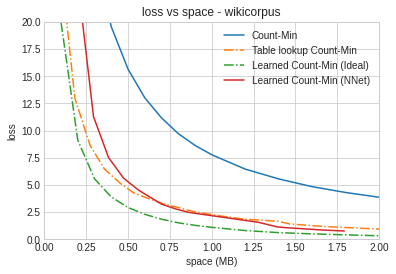

In [11]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_min_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [0.103]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()

In [ ]:
# print('Running: with lookup, count sketch...')
# COUNT_SKETCH = True
# PERFECT_ORDER = False
# # with lookup

# lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
#                                 valid_results=VALID_RESULTS,
#                                 test_data=TEST_DATA, 
#                                 valid_data=VALID_DATA,
#                                 lookup_data=LOOKUP_DATA,
#                                 save=SAVE, 
#                                 seed=SEED,
#                                 space_list=SPACE_LIST,
#                                 n_hashes_list=N_HASHES_LIST,
#                                 perfect_order=PERFECT_ORDER,
#                                 n_workers=N_WORKERS, 
#                                 data_name=DATA_NAME,
#                                 count_sketch=COUNT_SKETCH
#                             )

# lcm.run()

In [7]:
print('Running: no lookup, only using learned model count sketch...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: no lookup, only using learned model count sketch...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-5811c0cb-a3fb-4648-9803-4058b6fd74b3.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


data loading time: 11.3 sec
	loss_cf 0.00	loss_rd 4.97	loss_avg 4.03
cutoff_count_sketch_param: bcut: 18750, # hashes 1, # buckets 56250 - loss 4.03	 time: 21.43 sec
	loss_cf 0.00	loss_rd 4.92	loss_avg 3.61
cutoff_count_sketch_param: bcut: 35000, # hashes 1, # buckets 65000 - loss 3.61	 time: 21.82 sec
	loss_cf 0.00	loss_rd 5.37	loss_avg 4.63
cutoff_count_sketch_param: bcut: 7500, 

cutoff_count_sketch_param: bcut: 10000, # hashes 2, # buckets 12500 - loss 17.43	 time: 23.44 sec
	loss_cf 0.00	loss_rd 8.67	loss_avg 5.98
cutoff_count_sketch_param: bcut: 45000, # hashes 1, # buckets 55000 - loss 5.98	 time: 19.22 sec
	loss_cf 0.00	loss_rd 9.18	loss_avg 8.45
cutoff_count_sketch_param: bcut: 2500, # hashes 4, # buckets 7500 - loss 8.45	 time: 27.60 sec
	loss_cf 0.00	loss_rd 6.31	loss_avg 4.88
cutoff_count_sketch_param: bcut: 26250, # hashes 1, # buckets 48750 - loss 4.88	 time: 20.94 sec
	loss_cf 0.00	loss_rd 4.10	loss_avg 3.70
cutoff_count_sketch_param: bcut: 3750, # hashes 3, # buckets 26250 - loss 3.70	 time: 25.29 sec
	loss_cf 0.00	loss_rd 3.64	loss_avg 3.02
cutoff_count_sketch_param: bcut: 15000, # hashes 3, # buckets 38333 - loss 3.02	 time: 23.76 sec
	loss_cf 0.00	loss_rd 6.44	loss_avg 5.41
cutoff_count_sketch_param: bcut: 12500, # hashes 1, # buckets 37500 - loss 5.41	 time: 21.29 sec
	loss_cf 0.00	loss_rd 9.74	loss_avg 6.72
cutoff_count_sketch_param: bcut: 450

cutoff_count_sketch_param: bcut: 2500, # hashes 2, # buckets 25000 - loss 5.97	 time: 23.92 sec
	loss_cf 0.00	loss_rd 4.20	loss_avg 3.27
cutoff_count_sketch_param: bcut: 25000, # hashes 3, # buckets 41666 - loss 3.27	 time: 23.55 sec
	loss_cf 0.00	loss_rd 3.21	loss_avg 2.70
cutoff_count_sketch_param: bcut: 12500, # hashes 2, # buckets 62500 - loss 2.70	 time: 22.60 sec
	loss_cf 0.00	loss_rd 8.72	loss_avg 7.12
cutoff_count_sketch_param: bcut: 17500, # hashes 1, # buckets 32500 - loss 7.12	 time: 21.35 sec
	loss_cf 0.00	loss_rd 4.43	loss_avg 3.74
cutoff_count_sketch_param: bcut: 11250, # hashes 3, # buckets 28750 - loss 3.74	 time: 25.38 sec
	loss_cf 0.00	loss_rd 12.79	loss_avg 9.45
cutoff_count_sketch_param: bcut: 33750, # hashes 2, # buckets 37500 - loss 9.45	 time: 22.10 sec
	loss_cf 0.00	loss_rd 10.45	loss_avg 9.11
cutoff_count_sketch_param: bcut: 6250, # hashes 1, # buckets 18750 - loss 9.11	 time: 21.87 sec
	loss_cf 0.00	loss_rd 4.17	loss_avg 3.24
cutoff_count_sketch_param: bcut: 2

cutoff_count_sketch_param: bcut: 70000, # hashes 1, # buckets 105000 - loss 2.12	 time: 16.74 sec
	loss_cf 0.00	loss_rd 7.39	loss_avg 4.72
cutoff_count_sketch_param: bcut: 56250, # hashes 4, # buckets 59375 - loss 4.72	 time: 20.95 sec
	loss_cf 0.00	loss_rd 2.26	loss_avg 1.84
cutoff_count_sketch_param: bcut: 17500, # hashes 3, # buckets 64166 - loss 1.84	 time: 24.54 sec
	loss_cf 0.00	loss_rd 3.44	loss_avg 2.37
cutoff_count_sketch_param: bcut: 45000, # hashes 2, # buckets 75000 - loss 2.37	 time: 20.00 sec
	loss_cf 0.00	loss_rd 2.23	loss_avg 1.59
cutoff_count_sketch_param: bcut: 40000, # hashes 3, # buckets 80000 - loss 1.59	 time: 20.47 sec
	loss_cf 0.00	loss_rd 3.93	loss_avg 2.35
cutoff_count_sketch_param: bcut: 70000, # hashes 2, # buckets 87500 - loss 2.35	 time: 17.98 sec
	loss_cf 0.00	loss_rd 1.72	loss_avg 1.45
cutoff_count_sketch_param: bcut: 11250, # hashes 1, # buckets 213750 - loss 1.45	 time: 20.98 sec
	loss_cf 0.00	loss_rd 3.28	loss_avg 2.55
cutoff_count_sketch_param: bcut:

cutoff_count_sketch_param: bcut: 60000, # hashes 3, # buckets 86666 - loss 1.57	 time: 19.16 sec
	loss_cf 0.00	loss_rd 2.48	loss_avg 1.82
cutoff_count_sketch_param: bcut: 35000, # hashes 3, # buckets 70000 - loss 1.82	 time: 21.40 sec
	loss_cf 0.00	loss_rd 2.56	loss_avg 2.12
cutoff_count_sketch_param: bcut: 15000, # hashes 4, # buckets 45000 - loss 2.12	 time: 24.56 sec
	loss_cf 0.00	loss_rd 3.91	loss_avg 2.83
cutoff_count_sketch_param: bcut: 37500, # hashes 3, # buckets 54166 - loss 2.83	 time: 22.70 sec
	loss_cf 0.00	loss_rd 4.49	loss_avg 2.80
cutoff_count_sketch_param: bcut: 60000, # hashes 3, # buckets 70000 - loss 2.80	 time: 20.40 sec
	loss_cf 0.00	loss_rd 1.71	loss_avg 1.26
cutoff_count_sketch_param: bcut: 33750, # hashes 1, # buckets 191250 - loss 1.26	 time: 18.75 sec
	loss_cf 0.00	loss_rd 2.45	loss_avg 1.53
cutoff_count_sketch_param: bcut: 60000, # hashes 4, # buckets 80000 - loss 1.53	 time: 19.89 sec
	loss_cf 0.00	loss_rd 1.99	loss_avg 1.69
cutoff_count_sketch_param: bcut: 

cutoff_count_sketch_param: bcut: 50000, # hashes 3, # buckets 58333 - loss 3.56	 time: 20.18 sec
	loss_cf 0.00	loss_rd 2.18	loss_avg 1.87
cutoff_count_sketch_param: bcut: 8750, # hashes 3, # buckets 61250 - loss 1.87	 time: 23.34 sec
	loss_cf 0.00	loss_rd 1.81	loss_avg 1.15
cutoff_count_sketch_param: bcut: 56250, # hashes 1, # buckets 168750 - loss 1.15	 time: 16.79 sec
	loss_cf 0.00	loss_rd 2.80	loss_avg 2.12
cutoff_count_sketch_param: bcut: 30000, # hashes 4, # buckets 52500 - loss 2.12	 time: 23.78 sec
	loss_cf 0.00	loss_rd 4.72	loss_avg 2.62
cutoff_count_sketch_param: bcut: 90000, # hashes 1, # buckets 110000 - loss 2.62	 time: 15.05 sec
	loss_cf 0.00	loss_rd 2.80	loss_avg 1.84
cutoff_count_sketch_param: bcut: 52500, # hashes 4, # buckets 70000 - loss 1.84	 time: 21.75 sec
	loss_cf 0.00	loss_rd 5.20	loss_avg 3.47
cutoff_count_sketch_param: bcut: 50000, # hashes 4, # buckets 56250 - loss 3.47	 time: 21.40 sec
	loss_cf 0.00	loss_rd 2.09	loss_avg 1.58
cutoff_count_sketch_param: bcut: 

	loss_cf 0.00	loss_rd 4.17	loss_avg 2.11
cutoff_count_sketch_param: bcut: 112500, # hashes 4, # buckets 118750 - loss 2.11	 time: 17.83 sec
	loss_cf 0.00	loss_rd 1.63	loss_avg 0.96
cutoff_count_sketch_param: bcut: 75000, # hashes 4, # buckets 112500 - loss 0.96	 time: 19.91 sec
	loss_cf 0.00	loss_rd 1.00	loss_avg 0.58
cutoff_count_sketch_param: bcut: 80000, # hashes 1, # buckets 320000 - loss 0.58	 time: 16.25 sec
	loss_cf 0.00	loss_rd 1.63	loss_avg 1.09
cutoff_count_sketch_param: bcut: 50000, # hashes 1, # buckets 200000 - loss 1.09	 time: 17.51 sec
	loss_cf 0.00	loss_rd 2.58	loss_avg 1.50
cutoff_count_sketch_param: bcut: 78750, # hashes 4, # buckets 95625 - loss 1.50	 time: 19.76 sec
	loss_cf 0.00	loss_rd 1.47	loss_avg 1.08
cutoff_count_sketch_param: bcut: 35000, # hashes 2, # buckets 175000 - loss 1.08	 time: 21.00 sec
	loss_cf 0.00	loss_rd 2.35	loss_avg 1.05
cutoff_count_sketch_param: bcut: 140000, # hashes 2, # buckets 175000 - loss 1.05	 time: 14.51 sec
	loss_cf 0.00	loss_rd 1.61

cutoff_count_sketch_param: bcut: 120000, # hashes 2, # buckets 200000 - loss 0.72	 time: 14.42 sec
	loss_cf 0.00	loss_rd 1.48	loss_avg 1.12
cutoff_count_sketch_param: bcut: 30000, # hashes 3, # buckets 110000 - loss 1.12	 time: 21.84 sec
	loss_cf 0.00	loss_rd 4.59	loss_avg 2.44
cutoff_count_sketch_param: bcut: 101250, # hashes 4, # buckets 106875 - loss 2.44	 time: 17.40 sec
	loss_cf 0.00	loss_rd 1.13	loss_avg 0.68
cutoff_count_sketch_param: bcut: 70000, # hashes 1, # buckets 280000 - loss 0.68	 time: 17.04 sec
	loss_cf 0.00	loss_rd 1.14	loss_avg 0.92
cutoff_count_sketch_param: bcut: 20000, # hashes 3, # buckets 140000 - loss 0.92	 time: 22.68 sec
	loss_cf 0.00	loss_rd 1.86	loss_avg 1.09
cutoff_count_sketch_param: bcut: 75000, # hashes 1, # buckets 175000 - loss 1.09	 time: 17.08 sec
	loss_cf 0.00	loss_rd 2.60	loss_avg 1.27
cutoff_count_sketch_param: bcut: 120000, # hashes 2, # buckets 150000 - loss 1.27	 time: 14.92 sec
	loss_cf 0.00	loss_rd 1.41	loss_avg 0.69
cutoff_count_sketch_para

	loss_cf 0.00	loss_rd 0.12	loss_avg 0.00
cutoff_count_sketch_param: bcut: 337500, # hashes 1, # buckets 412500 - loss 0.00	 time: 2.04 sec
	loss_cf 0.00	loss_rd 1.24	loss_avg 0.63
cutoff_count_sketch_param: bcut: 112500, # hashes 2, # buckets 225000 - loss 0.63	 time: 15.24 sec
	loss_cf 0.00	loss_rd 0.17	loss_avg 0.00
cutoff_count_sketch_param: bcut: 337500, # hashes 2, # buckets 375000 - loss 0.00	 time: 1.96 sec
	loss_cf 0.00	loss_rd 1.37	loss_avg 0.72
cutoff_count_sketch_param: bcut: 105000, # hashes 1, # buckets 245000 - loss 0.72	 time: 15.25 sec
	loss_cf 0.00	loss_rd 0.07	loss_avg 0.00
cutoff_count_sketch_param: bcut: 337500, # hashes 3, # buckets 362500 - loss 0.00	 time: 2.09 sec
	loss_cf 0.00	loss_rd 1.28	loss_avg 0.48
cutoff_count_sketch_param: bcut: 175000, # hashes 2, # buckets 250000 - loss 0.48	 time: 11.86 sec
	loss_cf 0.00	loss_rd 0.11	loss_avg 0.00
cutoff_count_sketch_param: bcut: 337500, # hashes 4, # buckets 356250 - loss 0.00	 time: 1.99 sec
	loss_cf 0.00	loss_rd 0.

cutoff_count_sketch_param: bcut: 50000, # hashes 4, # buckets 150000 - loss 0.65	 time: 21.11 sec
	loss_cf 0.00	loss_rd 1.25	loss_avg 0.57
cutoff_count_sketch_param: bcut: 135000, # hashes 4, # buckets 180000 - loss 0.57	 time: 15.82 sec
	loss_cf 0.00	loss_rd 0.51	loss_avg 0.18
cutoff_count_sketch_param: bcut: 187500, # hashes 1, # buckets 562500 - loss 0.18	 time: 10.21 sec
	loss_cf 0.00	loss_rd 1.93	loss_avg 0.51
cutoff_count_sketch_param: bcut: 225000, # hashes 3, # buckets 241666 - loss 0.51	 time: 9.49 sec
	loss_cf 0.00	loss_rd 1.04	loss_avg 0.82
cutoff_count_sketch_param: bcut: 22500, # hashes 3, # buckets 157500 - loss 0.82	 time: 22.01 sec
	loss_cf 0.00	loss_rd 0.35	loss_avg 0.18
cutoff_count_sketch_param: bcut: 100000, # hashes 1, # buckets 900000 - loss 0.18	 time: 15.28 sec
	loss_cf 0.00	loss_rd 1.26	loss_avg 0.51
cutoff_count_sketch_param: bcut: 157500, # hashes 1, # buckets 292500 - loss 0.51	 time: 12.04 sec
	loss_cf 0.00	loss_rd 0.70	loss_avg 0.24
cutoff_count_sketch_par

	loss_cf 0.00	loss_rd 2.35	loss_avg 0.73
cutoff_count_sketch_param: bcut: 202500, # hashes 3, # buckets 217500 - loss 0.73	 time: 10.54 sec
	loss_cf 0.00	loss_rd 0.46	loss_avg 0.15
cutoff_count_sketch_param: bcut: 200000, # hashes 2, # buckets 500000 - loss 0.15	 time: 10.26 sec
	loss_cf 0.00	loss_rd 1.00	loss_avg 0.53
cutoff_count_sketch_param: bcut: 100000, # hashes 4, # buckets 175000 - loss 0.53	 time: 17.37 sec
	loss_cf 0.00	loss_rd 2.30	loss_avg 0.71
cutoff_count_sketch_param: bcut: 202500, # hashes 4, # buckets 213750 - loss 0.71	 time: 10.45 sec
	loss_cf 0.00	loss_rd 0.30	loss_avg 0.09
cutoff_count_sketch_param: bcut: 200000, # hashes 3, # buckets 400000 - loss 0.09	 time: 10.57 sec
	loss_cf 0.00	loss_rd 0.59	loss_avg 0.34
cutoff_count_sketch_param: bcut: 75000, # hashes 3, # buckets 275000 - loss 0.34	 time: 19.00 sec
	loss_cf 0.00	loss_rd 1.10	loss_avg 0.66
cutoff_count_sketch_param: bcut: 67500, # hashes 2, # buckets 225000 - loss 0.66	 time: 19.60 sec
	loss_cf 0.00	loss_rd 

In [8]:
print('Running: perfect oracle... only using learned model count sketch...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: perfect oracle... only using learned model count sketch...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-5811c0cb-a3fb-4648-9803-4058b6fd74b3.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


data loading time: 0.6 sec
	loss_cf 0.00	loss_rd 2.90	loss_avg 1.66
cutoff_count_sketch_param_perfect: bcut: 35000, # hashes 1, # buckets 65000 - loss 1.66	 time: 18.26 sec
	loss_cf 0.00	loss_rd 2.98	loss_avg 1.94
cutoff_count_sketch_param_perfect: bcut: 18750, # hashes 1, # buckets 56250 - loss 1.94	 time: 20.44 sec
	loss_cf 0.00	loss_rd 6.49	loss_avg 5.60
cutoff_count_sket

cutoff_count_sketch_param_perfect: bcut: 3750, # hashes 2, # buckets 37500 - loss 2.52	 time: 21.31 sec
	loss_cf 0.00	loss_rd 7.01	loss_avg 5.78
cutoff_count_sketch_param_perfect: bcut: 2500, # hashes 4, # buckets 7500 - loss 5.78	 time: 26.13 sec
	loss_cf 0.00	loss_rd 2.32	loss_avg 1.57
cutoff_count_sketch_param_perfect: bcut: 15000, # hashes 2, # buckets 50000 - loss 1.57	 time: 21.12 sec
	loss_cf 0.00	loss_rd 4.79	loss_avg 2.59
cutoff_count_sketch_param_perfect: bcut: 45000, # hashes 1, # buckets 55000 - loss 2.59	 time: 18.74 sec
	loss_cf 0.00	loss_rd 4.24	loss_avg 3.04
cutoff_count_sketch_param_perfect: bcut: 10000, # hashes 4, # buckets 17500 - loss 3.04	 time: 24.27 sec
	loss_cf 0.00	loss_rd 9.55	loss_avg 6.85
cutoff_count_sketch_param_perfect: bcut: 10000, # hashes 2, # buckets 12500 - loss 6.85	 time: 22.24 sec
	loss_cf 0.00	loss_rd 3.59	loss_avg 2.19
cutoff_count_sketch_param_perfect: bcut: 26250, # hashes 1, # buckets 48750 - loss 2.19	 time: 19.66 sec
	loss_cf 0.00	loss_rd 

cutoff_count_sketch_param_perfect: bcut: 25000, # hashes 2, # buckets 50000 - loss 1.53	 time: 20.87 sec
	loss_cf 0.00	loss_rd 1.91	loss_avg 1.33
cutoff_count_sketch_param_perfect: bcut: 12500, # hashes 1, # buckets 112500 - loss 1.33	 time: 19.72 sec
	loss_cf 0.00	loss_rd 4.78	loss_avg 3.23
cutoff_count_sketch_param_perfect: bcut: 15000, # hashes 4, # buckets 20000 - loss 3.23	 time: 23.83 sec
	loss_cf 0.00	loss_rd 4.21	loss_avg 3.47
cutoff_count_sketch_param_perfect: bcut: 2500, # hashes 2, # buckets 25000 - loss 3.47	 time: 22.36 sec
	loss_cf 0.00	loss_rd 2.87	loss_avg 2.02
cutoff_count_sketch_param_perfect: bcut: 11250, # hashes 2, # buckets 37500 - loss 2.02	 time: 21.56 sec
	loss_cf 0.00	loss_rd 6.91	loss_avg 5.37
cutoff_count_sketch_param_perfect: bcut: 5000, # hashes 4, # buckets 8750 - loss 5.37	 time: 24.95 sec
	loss_cf 0.00	loss_rd 5.88	loss_avg 3.39
cutoff_count_sketch_param_perfect: bcut: 33750, # hashes 1, # buckets 41250 - loss 3.39	 time: 19.64 sec
	loss_cf 0.00	loss_rd

cutoff_count_sketch_param_perfect: bcut: 37500, # hashes 4, # buckets 56250 - loss 1.11	 time: 21.76 sec
	loss_cf 0.00	loss_rd 1.57	loss_avg 1.03
cutoff_count_sketch_param_perfect: bcut: 17500, # hashes 2, # buckets 87500 - loss 1.03	 time: 20.97 sec
	loss_cf 0.00	loss_rd 4.63	loss_avg 2.32
cutoff_count_sketch_param_perfect: bcut: 56250, # hashes 3, # buckets 60416 - loss 2.32	 time: 20.92 sec
	loss_cf 0.00	loss_rd 1.95	loss_avg 1.20
cutoff_count_sketch_param_perfect: bcut: 25000, # hashes 1, # buckets 100000 - loss 1.20	 time: 19.15 sec
	loss_cf 0.00	loss_rd 1.42	loss_avg 0.79
cutoff_count_sketch_param_perfect: bcut: 40000, # hashes 2, # buckets 100000 - loss 0.79	 time: 19.38 sec
	loss_cf 0.00	loss_rd 3.08	loss_avg 1.31
cutoff_count_sketch_param_perfect: bcut: 90000, # hashes 4, # buckets 95000 - loss 1.31	 time: 18.62 sec
	loss_cf 0.00	loss_rd 2.08	loss_avg 1.01
cutoff_count_sketch_param_perfect: bcut: 61250, # hashes 4, # buckets 74375 - loss 1.01	 time: 20.84 sec
	loss_cf 0.00	los

cutoff_count_sketch_param_perfect: bcut: 22500, # hashes 3, # buckets 82500 - loss 0.92	 time: 21.38 sec
	loss_cf 0.00	loss_rd 1.76	loss_avg 1.19
cutoff_count_sketch_param_perfect: bcut: 15000, # hashes 2, # buckets 75000 - loss 1.19	 time: 21.23 sec
	loss_cf 0.00	loss_rd 1.55	loss_avg 0.89
cutoff_count_sketch_param_perfect: bcut: 35000, # hashes 2, # buckets 87500 - loss 0.89	 time: 19.64 sec
	loss_cf 0.00	loss_rd 1.54	loss_avg 0.75
cutoff_count_sketch_param_perfect: bcut: 60000, # hashes 2, # buckets 100000 - loss 0.75	 time: 20.41 sec
	loss_cf 0.00	loss_rd 2.52	loss_avg 1.23
cutoff_count_sketch_param_perfect: bcut: 60000, # hashes 1, # buckets 90000 - loss 1.23	 time: 17.43 sec
	loss_cf 0.00	loss_rd 1.40	loss_avg 1.01
cutoff_count_sketch_param_perfect: bcut: 10000, # hashes 1, # buckets 190000 - loss 1.01	 time: 20.39 sec
	loss_cf 0.00	loss_rd 2.20	loss_avg 1.24
cutoff_count_sketch_param_perfect: bcut: 37500, # hashes 1, # buckets 87500 - loss 1.24	 time: 18.36 sec
	loss_cf 0.00	los

cutoff_count_sketch_param_perfect: bcut: 45000, # hashes 3, # buckets 90000 - loss 0.79	 time: 19.94 sec
	loss_cf 0.00	loss_rd 1.56	loss_avg 1.14
cutoff_count_sketch_param_perfect: bcut: 8750, # hashes 1, # buckets 166250 - loss 1.14	 time: 19.99 sec
	loss_cf 0.00	loss_rd 1.73	loss_avg 0.89
cutoff_count_sketch_param_perfect: bcut: 52500, # hashes 2, # buckets 87500 - loss 0.89	 time: 19.34 sec
	loss_cf 0.00	loss_rd 1.73	loss_avg 1.03
cutoff_count_sketch_param_perfect: bcut: 30000, # hashes 2, # buckets 75000 - loss 1.03	 time: 20.23 sec
	loss_cf 0.00	loss_rd 1.54	loss_avg 0.99
cutoff_count_sketch_param_perfect: bcut: 20000, # hashes 4, # buckets 60000 - loss 0.99	 time: 23.85 sec
	loss_cf 0.00	loss_rd 2.94	loss_avg 1.54
cutoff_count_sketch_param_perfect: bcut: 50000, # hashes 1, # buckets 75000 - loss 1.54	 time: 17.25 sec
	loss_cf 0.00	loss_rd 2.34	loss_avg 1.04
cutoff_count_sketch_param_perfect: bcut: 80000, # hashes 3, # buckets 93333 - loss 1.04	 time: 19.73 sec
	loss_cf 0.00	loss_

	loss_cf 0.00	loss_rd 0.88	loss_avg 0.43
cutoff_count_sketch_param_perfect: bcut: 60000, # hashes 3, # buckets 153333 - loss 0.43	 time: 19.20 sec
	loss_cf 0.00	loss_rd 2.41	loss_avg 0.94
cutoff_count_sketch_param_perfect: bcut: 112500, # hashes 1, # buckets 137500 - loss 0.94	 time: 15.07 sec
	loss_cf 0.00	loss_rd 1.18	loss_avg 0.67
cutoff_count_sketch_param_perfect: bcut: 37500, # hashes 2, # buckets 125000 - loss 0.67	 time: 20.49 sec
	loss_cf 0.00	loss_rd 1.52	loss_avg 0.68
cutoff_count_sketch_param_perfect: bcut: 78750, # hashes 1, # buckets 146250 - loss 0.68	 time: 16.84 sec
	loss_cf 0.00	loss_rd 1.05	loss_avg 0.47
cutoff_count_sketch_param_perfect: bcut: 75000, # hashes 2, # buckets 150000 - loss 0.47	 time: 18.66 sec
	loss_cf 0.00	loss_rd 1.29	loss_avg 0.48
cutoff_count_sketch_param_perfect: bcut: 122500, # hashes 3, # buckets 157500 - loss 0.48	 time: 15.06 sec
	loss_cf 0.00	loss_rd 2.43	loss_avg 0.94
cutoff_count_sketch_param_perfect: bcut: 112500, # hashes 2, # buckets 1250

cutoff_count_sketch_param_perfect: bcut: 52500, # hashes 2, # buckets 175000 - loss 0.47	 time: 19.01 sec
	loss_cf 0.00	loss_rd 0.95	loss_avg 0.39
cutoff_count_sketch_param_perfect: bcut: 100000, # hashes 3, # buckets 166666 - loss 0.39	 time: 17.13 sec
	loss_cf 0.00	loss_rd 1.14	loss_avg 0.55
cutoff_count_sketch_param_perfect: bcut: 62500, # hashes 1, # buckets 187500 - loss 0.55	 time: 17.42 sec
	loss_cf 0.00	loss_rd 1.28	loss_avg 0.51
cutoff_count_sketch_param_perfect: bcut: 105000, # hashes 2, # buckets 150000 - loss 0.51	 time: 15.92 sec
	loss_cf 0.00	loss_rd 2.59	loss_avg 1.06
cutoff_count_sketch_param_perfect: bcut: 101250, # hashes 1, # buckets 123750 - loss 1.06	 time: 15.53 sec
	loss_cf 0.00	loss_rd 0.77	loss_avg 0.50
cutoff_count_sketch_param_perfect: bcut: 20000, # hashes 1, # buckets 380000 - loss 0.50	 time: 19.32 sec
	loss_cf 0.00	loss_rd 0.94	loss_avg 0.56
cutoff_count_sketch_param_perfect: bcut: 30000, # hashes 1, # buckets 270000 - loss 0.56	 time: 21.16 sec
	loss_cf 

cutoff_count_sketch_param_perfect: bcut: 45000, # hashes 3, # buckets 115000 - loss 0.62	 time: 20.58 sec
	loss_cf 0.00	loss_rd 0.92	loss_avg 0.51
cutoff_count_sketch_param_perfect: bcut: 40000, # hashes 3, # buckets 146666 - loss 0.51	 time: 22.53 sec
	loss_cf 0.00	loss_rd 1.41	loss_avg 0.98
cutoff_count_sketch_param_perfect: bcut: 12500, # hashes 4, # buckets 68750 - loss 0.98	 time: 24.08 sec
	loss_cf 0.00	loss_rd 0.95	loss_avg 0.41
cutoff_count_sketch_param_perfect: bcut: 87500, # hashes 2, # buckets 175000 - loss 0.41	 time: 17.10 sec
	loss_cf 0.00	loss_rd 1.41	loss_avg 0.61
cutoff_count_sketch_param_perfect: bcut: 87500, # hashes 1, # buckets 162500 - loss 0.61	 time: 16.45 sec
	loss_cf 0.00	loss_rd 1.13	loss_avg 0.35
cutoff_count_sketch_param_perfect: bcut: 160000, # hashes 1, # buckets 240000 - loss 0.35	 time: 11.92 sec
	loss_cf 0.00	loss_rd 2.29	loss_avg 0.80
cutoff_count_sketch_param_perfect: bcut: 135000, # hashes 4, # buckets 142500 - loss 0.80	 time: 15.41 sec
	loss_cf 0.

cutoff_count_sketch_param_perfect: bcut: 50000, # hashes 2, # buckets 250000 - loss 0.37	 time: 18.73 sec
	loss_cf 0.00	loss_rd 0.35	loss_avg 0.12
cutoff_count_sketch_param_perfect: bcut: 150000, # hashes 1, # buckets 600000 - loss 0.12	 time: 13.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 350000, # hashes 1, # buckets 650000 - loss 0.00	 time: 1.53 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 350000, # hashes 2, # buckets 500000 - loss 0.00	 time: 1.51 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 350000, # hashes 3, # buckets 450000 - loss 0.00	 time: 1.58 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 350000, # hashes 4, # buckets 425000 - loss 0.00	 time: 1.67 sec
	loss_cf 0.00	loss_rd 0.84	loss_avg 0.29
cutoff_count_sketch_param_perfect: bcut: 135000, # hashes 2, # buckets 225000 - loss 0.29	 time: 14.16 sec
	loss_cf 0

cutoff_count_sketch_param_perfect: bcut: 250000, # hashes 1, # buckets 750000 - loss 0.03	 time: 6.96 sec
	loss_cf 0.00	loss_rd 0.72	loss_avg 0.26
cutoff_count_sketch_param_perfect: bcut: 125000, # hashes 2, # buckets 250000 - loss 0.26	 time: 14.95 sec
	loss_cf 0.00	loss_rd 0.78	loss_avg 0.48
cutoff_count_sketch_param_perfect: bcut: 25000, # hashes 2, # buckets 250000 - loss 0.48	 time: 19.98 sec
	loss_cf 0.00	loss_rd 0.27	loss_avg 0.04
cutoff_count_sketch_param_perfect: bcut: 250000, # hashes 2, # buckets 500000 - loss 0.04	 time: 7.36 sec
	loss_cf 0.00	loss_rd 0.78	loss_avg 0.36
cutoff_count_sketch_param_perfect: bcut: 67500, # hashes 4, # buckets 146250 - loss 0.36	 time: 19.67 sec
	loss_cf 0.00	loss_rd 0.53	loss_avg 0.24
cutoff_count_sketch_param_perfect: bcut: 75000, # hashes 4, # buckets 225000 - loss 0.24	 time: 19.07 sec
	loss_cf 0.00	loss_rd 0.78	loss_avg 0.29
cutoff_count_sketch_param_perfect: bcut: 125000, # hashes 3, # buckets 208333 - loss 0.29	 time: 14.65 sec
	loss_cf 0

# Plot Count-Sketch

plot testing results for lookup table
plot testing results for perfect CCM


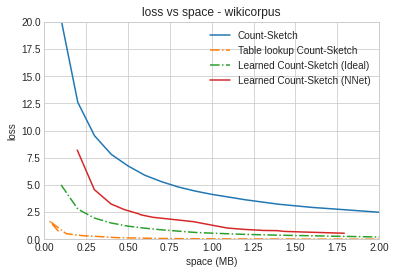

In [9]:
ALGO = 'Count-Sketch'
COUNT_MIN = 'param_results/count_sketch/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_sketch_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_sketch_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_sketch/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Sketch (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [model_size]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()

plot testing results for perfect CCM


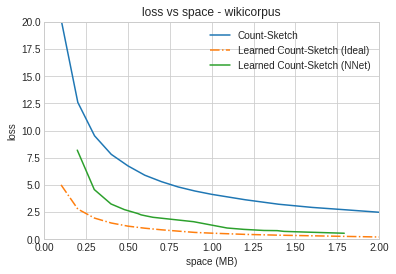

In [12]:
ALGO = 'Count-Sketch'
COUNT_MIN = 'param_results/count_sketch/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_sketch_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_sketch_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_sketch/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Sketch (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [0.103]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=None,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()